# Let's build all kind of auto-de models.

In [1]:
#imports
import os
import pandas as pd
import re
import numpy as np
from tqdm import tqdm
from ioh_xplainer import explainer
import pandas as pd
import ioh
from scipy.stats import qmc
from ConfigSpace import ConfigurationSpace
from ConfigSpace.util import generate_grid
from IPython.display import display
from time import monotonic
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from matplotlib import pyplot as plt

/home/bas/repos/ioh-explainer/env/lib/python3.8/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/bas/repos/ioh-explainer/env/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/bas/repos/ioh-explainer/env/lib/python3.8/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/bas/repos/ioh-explainer/env/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
IProgress not found. Please update jupyter and ipywidgets. See

In [2]:
ela_df = pd.read_pickle("ela-features2.pkl")
features= ['F','CR', 'lambda_', 'mutation_base', 'mutation_reference',
       'mutation_n_comps', 'use_archive', 'crossover', 'adaptation_method',
       'lpsr']
ela_df.describe()

,CR,F,lambda_,mutation_n_comps,dim,fid,iid,auc,ela_meta.lin_simple.adj_r2,ela_meta.lin_simple.intercept,...,disp.diff_median_05,disp.diff_median_10,disp.diff_median_25,disp.costs_runtime,ic.h_max,ic.eps_s,ic.eps_max,ic.eps_ratio,ic.m0,ic.costs_runtime
count,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,...,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,0.541042,0.471875,7.366667,1.337500,17.500000,12.500000,3.000000,6968.743741,0.412893,0.304977,...,-2.236977,-1.832161,-1.234911,0.034628,0.814460,-1.164248,0.008972,-1.969803,0.570708,0.533232
std,0.175821,0.168026,3.594355,0.473845,12.526123,6.936653,1.417169,2476.455146,0.309993,0.212899,...,1.196892,0.982634,0.647996,0.004453,0.047360,0.394365,0.010255,0.460592,0.061463,0.332146
min,0.050000,0.250000,6.000000,1.000000,5.000000,1.000000,1.000000,2308.641975,-0.012387,0.006332,...,-4.332638,-3.542501,-2.382481,0.027215,0.661395,-1.956957,0.000030,-4.139139,0.445892,0.291191
25%,0.500000,0.500000,6.000000,1.000000,5.000000,6.750000,2.000000,4511.574074,0.074131,0.146591,...,-3.242814,-2.708075,-1.830551,0.029946,0.780949,-1.516517,0.003488,-2.142142,0.505762,0.330300
50%,0.500000,0.500000,8.000000,1.000000,17.500000,12.500000,3.000000,7849.691358,0.436817,0.271535,...,-2.279125,-1.793952,-1.192525,0.036426,0.819140,-1.316316,0.005281,-2.017017,0.585170,0.544651
75%,0.500000,0.500000,8.000000,2.000000,30.000000,18.250000,4.000000,9481.481481,0.666846,0.393664,...,-1.467562,-1.198076,-0.825482,0.037580,0.856744,-0.815816,0.011563,-1.656657,0.614479,0.618603
max,1.000000,1.750000,60.000000,2.000000,30.000000,24.000000,5.000000,10000.000000,1.000000,0.972162,...,0.487208,0.316937,0.231666,0.046875,0.888130,-0.255255,0.066654,-0.995996,0.710421,3.154375


In [5]:
#load explainer
data_file = "df_huge.pkl" #read in modular DE data
df = pd.read_pickle(data_file)

config_dict = {}
for f in features:
    config_dict[f] = list(map(str, df[f].unique()))

config_dict['mutation_n_comps'] = [1,2]
config_dict['use_archive'] = [False, True]
config_dict['lpsr'] = [False, True]

#for each fid, iid get the best configuration  (mean?)
cs = ConfigurationSpace(config_dict)

print(cs)

de_explainer = explainer(None, 
                 cs , 
                 algname="mod-DE",
                 dims = [5,30],#, 10, 20, 40 
                 fids = np.arange(1,25), #,5
                 iids = df['iid'].unique(), #20 
                 reps = len( df['seed'].unique()), 
                 sampling_method = "grid",  #or random
                 grid_steps_dict = {},
                 sample_size = None,  #only used with random method
                 budget = 10000, #10000
                 seed = 1,
                 verbose = True)
de_explainer.load_results(data_file)

Configuration space object:
  Hyperparameters:
    CR, Type: Categorical, Choices: {0.5, 0.05, 0.25, 0.75, 1.0}, Default: 0.5
    F, Type: Categorical, Choices: {0.5, 0.25, 0.75, 1.25, 1.75}, Default: 0.5
    adaptation_method, Type: Categorical, Choices: {nan, jDE, shade}, Default: nan
    crossover, Type: Categorical, Choices: {exp, bin}, Default: exp
    lambda_, Type: Categorical, Choices: {8, 6, 10, 60, 150, 300}, Default: 8
    lpsr, Type: Categorical, Choices: {False, True}, Default: False
    mutation_base, Type: Categorical, Choices: {target, best, rand}, Default: target
    mutation_n_comps, Type: Categorical, Choices: {1, 2}, Default: 1
    mutation_reference, Type: Categorical, Choices: {pbest, rand, nan, best}, Default: pbest
    use_archive, Type: Categorical, Choices: {False, True}, Default: False



In [6]:
for f in features:
    print(f, ela_df[f].unique())

categorical_columns = features

df = ela_df.copy()
for cat in categorical_columns:
    print(cat)
    df[cat] = df[cat].astype('category')
    print(df[cat].unique())
    print(df[cat].cat.codes.unique())

ela_df_cat = ela_df.copy()
ela_df_cat[features] = ela_df_cat[features].apply(lambda col:pd.Categorical(col).codes)

F [0.5  0.25 0.75 1.75 1.25]
CR [0.5  0.75 1.   0.05 0.25]
lambda_ [ 6 10  8 60]
mutation_base ['best' 'rand' 'target']
mutation_reference ['rand' 'nan' 'pbest' 'best']
mutation_n_comps [1 2]
use_archive [False  True]
crossover ['bin' 'exp']
adaptation_method ['shade' 'nan' 'jDE']
lpsr [False  True]
F
[0.50, 0.25, 0.75, 1.75, 1.25]
Categories (5, float64): [0.25, 0.50, 0.75, 1.25, 1.75]
[1 0 2 4 3]
CR
[0.50, 0.75, 1.00, 0.05, 0.25]
Categories (5, float64): [0.05, 0.25, 0.50, 0.75, 1.00]
[2 3 4 0 1]
lambda_
[6, 10, 8, 60]
Categories (4, int64): [6, 8, 10, 60]
[0 2 1 3]
mutation_base
['best', 'rand', 'target']
Categories (3, object): ['best', 'rand', 'target']
[0 1 2]
mutation_reference
['rand', 'nan', 'pbest', 'best']
Categories (4, object): ['best', 'nan', 'pbest', 'rand']
[3 1 2 0]
mutation_n_comps
[1, 2]
Categories (2, int64): [1, 2]
[0 1]
use_archive
[False, True]
Categories (2, bool): [False, True]
[0 1]
crossover
['bin', 'exp']
Categories (2, object): ['bin', 'exp']
[0 1]
adaptati

5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
5 11
5 12
5 13
5 14
5 15
5 16
5 17
5 18
5 19
5 20
5 21
5 22
5 23
5 24
30 1
30 2
30 3
30 4
30 5
30 6
30 7
30 8
30 9
30 10
30 11
30 12
30 13
30 14
30 15
30 16
30 17
30 18
30 19
30 20
30 21
30 22
30 23
30 24


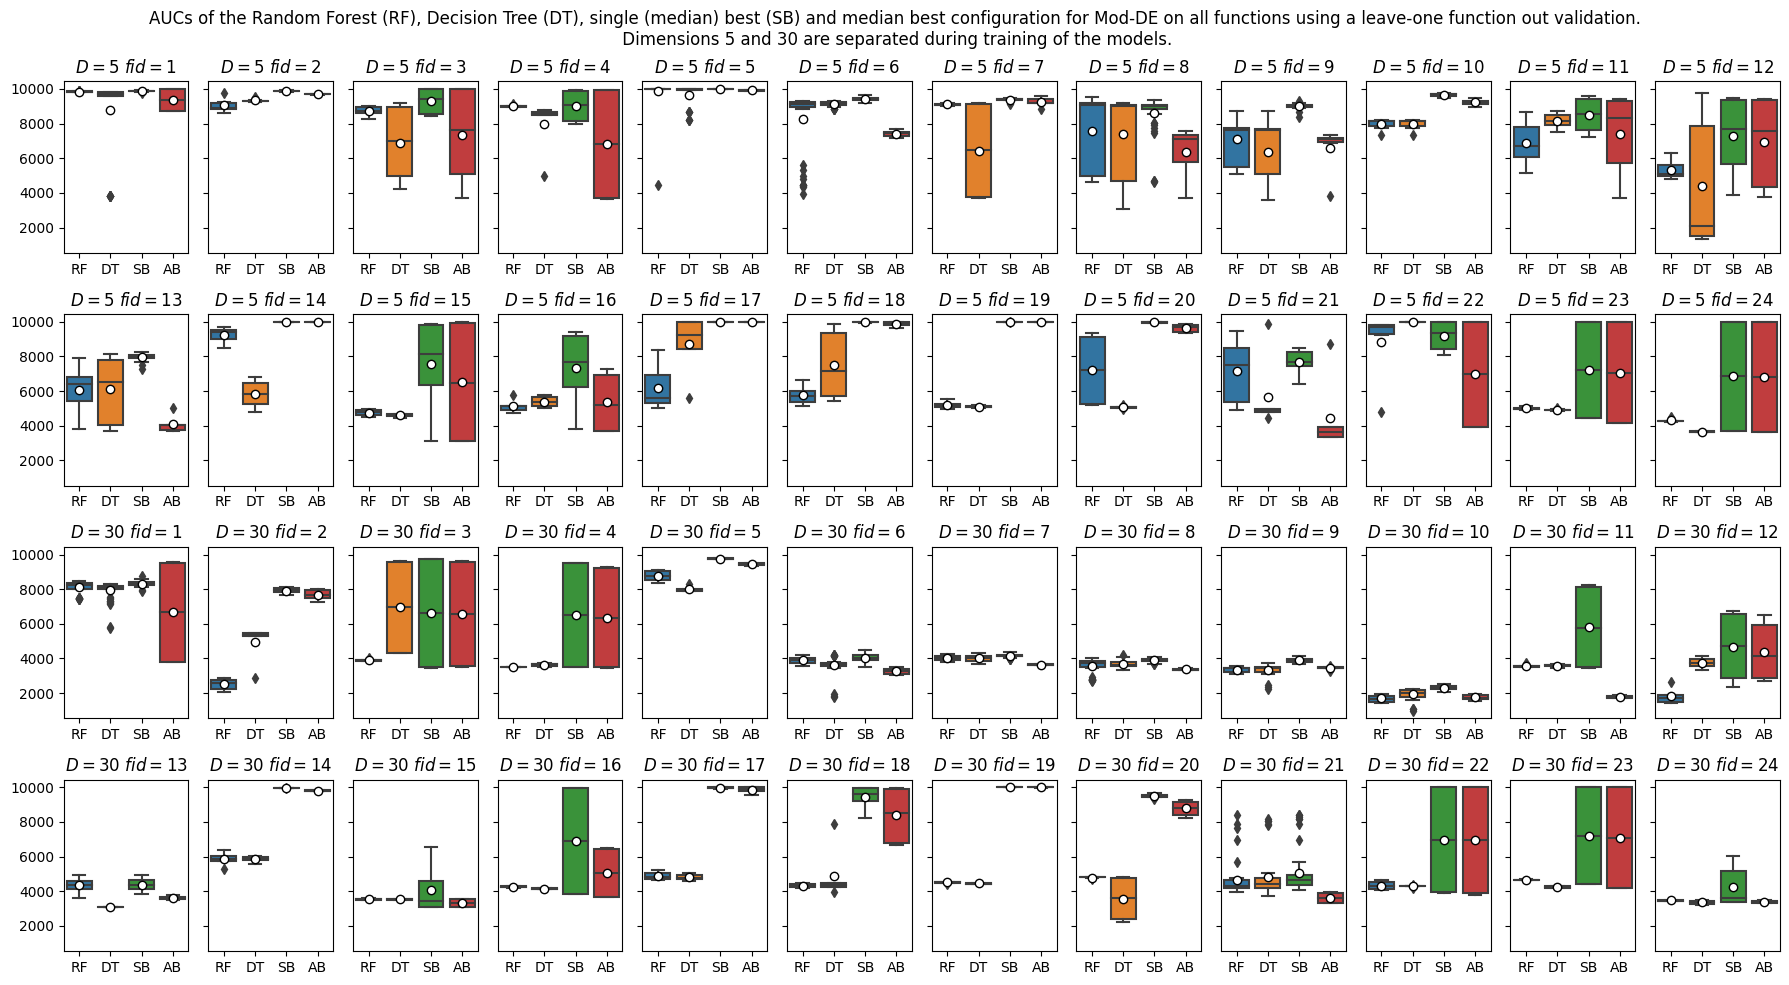

In [9]:

#leave one function out 
def predToNames(y, dim):

    mapping = [[0.25, 0.5, 0.75, 1.25, 1.75], [0.05, 0.25, 0.5,  0.75, 1.], [ 6, 8, 10, 60],['best', 'rand', 'target'], ['best','nan', 'pbest', 'rand'], 
                [1, 2], [False, True], ['bin', 'exp'], ['jDE', 'nan', 'shade'], [False, True]]
    newy = {}
    i = 0
    for f in features:
        newy[f] = mapping[i][y[i]]
        i+=1
    #transform a numerical representation back to the categorical names
    return newy

from matplotlib import pyplot as plt
import seaborn as sns

#preprocess the data to train and test
fig, axes = plt.subplots(4, 12, sharey=True, figsize=(18,10))
fig.suptitle('AUCs of the Random Forest (RF), Decision Tree (DT), single (median) best (SB) and median best configuration for Mod-DE on all functions using a leave-one function out validation.\n Dimensions 5 and 30 are separated during training of the models.')

dim_counter = 0
for dim in ela_df['dim'].unique():
    _, df_avg_best = de_explainer.get_average_best(dim)
    
    for fid in ela_df['fid'].unique():
        print(dim, fid)
        box_plot_df = pd.DataFrame(columns=['RF', 'DT','SB','AB'])

        _, df_single_best = de_explainer.get_single_best(fid, dim)
        box_plot_df['SB'] = pd.Series(df_single_best['auc'].values)
        box_plot_df['AB'] = pd.Series(df_avg_best[df_avg_best['fid'] == fid]['auc'].values)

        df = ela_df_cat[ela_df_cat['dim'] == dim]
        X_train = df[df['fid'] != fid].copy().drop(['fid','iid','auc',*features], axis=1)
        y_train = df[df['fid'] != fid][features]
        X_test = df[df['fid'] == fid].copy().drop(['fid','iid','auc',*features], axis=1)
        y_test = df[df['fid'] == fid][features]

        X_train.replace([np.inf, -np.inf], 0, inplace=True)
        X_test.replace([np.inf, -np.inf], 0, inplace=True)
        X_train.fillna(0, inplace=True)
        X_test.fillna(0, inplace=True)

        #y_train[features] = y_train[features].apply(lambda col:pd.Categorical(col).codes)
        #y_test[features] = y_test[features].apply(lambda col:pd.Categorical(col).codes)
    
        dtree = DecisionTreeClassifier(max_depth=7)
        dtree.fit(X_train, y_train)
        y_pred = dtree.predict(X_test)

        #RF
        rf = RandomForestClassifier()
        rf.fit(X_train, y_train)
        y_red_rf = rf.predict(X_test)

        iid = 1
        all_aucs = []
        all_aucs_rf = []
        for y in y_pred:
            #print(y)
            conf = predToNames(y, dim)
            #print(conf)
            aucs = de_explainer.get_results_for_config(conf, dim, fid, iid)
            all_aucs.extend(aucs.values)
            #print(all_aucs)
        for y in y_red_rf:
            #print(y)
            conf = predToNames(y, dim)
            #print(conf)
            aucs = de_explainer.get_results_for_config(conf, dim, fid, iid)
            all_aucs_rf.extend(aucs.values)
            #print(all_aucs)

        box_plot_df['DT'] = pd.Series(np.array(all_aucs)[:len(box_plot_df)])
        box_plot_df['RF'] = pd.Series(np.array(all_aucs_rf)[:len(box_plot_df)])
        sns.boxplot(ax=axes[dim_counter + int((fid-1)/12)][(fid-1)%12], data=box_plot_df, showfliers = True, showmeans=True,
                    meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"6"})  
        axes[dim_counter + int((fid-1)/12)][(fid-1)%12].set_title(f"$D={dim}$ $fid={fid}$")
        #axes[dim_counter + int((fid-1)/12)][(fid-1)%12].set_xticklabels(axes[dim_counter + int((fid-1)/12)][(fid-1)%12].get_xticks(), rotation=45)
    dim_counter += 2

plt.tight_layout()
plt.show()

plt.clf()
plt.close()

        

In [ ]:
#Leave one instance out
#preprocess the data to train and test
fig, axes = plt.subplots(4, 12, sharey=True, figsize=(18,10))
fig.suptitle('AUCs of the Random Forest (RF), Decision Tree (DT), single (median) best (SB) and median best configuration for Mod-DE on all functions using a leave-one function out validation.\n Dimensions 5 and 30 are separated during training of the models.')

dim_counter = 0
for dim in ela_df['dim'].unique():
    _, df_avg_best = de_explainer.get_average_best(dim)
    
    for fid in ela_df['fid'].unique():
        print(dim, fid)
        box_plot_df = pd.DataFrame(columns=['RF', 'DT','SB','AB'])

        _, df_single_best = de_explainer.get_single_best(fid, dim)
        box_plot_df['SB'] = pd.Series(df_single_best['auc'].values)
        box_plot_df['AB'] = pd.Series(df_avg_best[df_avg_best['fid'] == fid]['auc'].values)

        df = ela_df_cat[ela_df_cat['dim'] == dim]
        X_train = df[df['fid'] != fid].copy().drop(['fid','iid','auc',*features], axis=1)
        y_train = df[df['fid'] != fid][features]
        X_test = df[df['fid'] == fid].copy().drop(['fid','iid','auc',*features], axis=1)
        y_test = df[df['fid'] == fid][features]

        X_train.replace([np.inf, -np.inf], 0, inplace=True)
        X_test.replace([np.inf, -np.inf], 0, inplace=True)
        X_train.fillna(0, inplace=True)
        X_test.fillna(0, inplace=True)

        #y_train[features] = y_train[features].apply(lambda col:pd.Categorical(col).codes)
        #y_test[features] = y_test[features].apply(lambda col:pd.Categorical(col).codes)
    
        dtree = DecisionTreeClassifier(max_depth=7)
        dtree.fit(X_train, y_train)
        y_pred = dtree.predict(X_test)

        #RF
        rf = RandomForestClassifier()
        rf.fit(X_train, y_train)
        y_red_rf = rf.predict(X_test)

        iid = 1
        all_aucs = []
        all_aucs_rf = []
        for y in y_pred:
            #print(y)
            conf = predToNames(y, dim)
            #print(conf)
            aucs = de_explainer.get_results_for_config(conf, dim, fid, iid)
            all_aucs.extend(aucs.values)
            #print(all_aucs)
        for y in y_red_rf:
            #print(y)
            conf = predToNames(y, dim)
            #print(conf)
            aucs = de_explainer.get_results_for_config(conf, dim, fid, iid)
            all_aucs_rf.extend(aucs.values)
            #print(all_aucs)

        box_plot_df['DT'] = pd.Series(np.array(all_aucs)[:len(box_plot_df)])
        box_plot_df['RF'] = pd.Series(np.array(all_aucs_rf)[:len(box_plot_df)])
        sns.boxplot(ax=axes[dim_counter + int((fid-1)/12)][(fid-1)%12], data=box_plot_df, showfliers = True, showmeans=True,
                    meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"6"})  
        axes[dim_counter + int((fid-1)/12)][(fid-1)%12].set_title(f"$D={dim}$ $fid={fid}$")
        #axes[dim_counter + int((fid-1)/12)][(fid-1)%12].set_xticklabels(axes[dim_counter + int((fid-1)/12)][(fid-1)%12].get_xticks(), rotation=45)
    dim_counter += 2

plt.tight_layout()
plt.show()

plt.clf()
plt.close()